In [ ]:
# !pip install pyitlib
# from pyitlib import discrete_random_variable as drv
import numpy as np
from glob import glob
import os
from PIL import Image
import operator
from shutil import copyfile
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy.random as npr
import math
from skimage.measure import shannon_entropy

train_on_gpu = torch.cuda.is_available()
print('Run on GPU: ' + str(train_on_gpu))

Run on GPU: True


In [ ]:
'''ResNet18/34/50/101/152 in Pytorch.'''
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable


def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(in_planes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = conv3x3(3, 64)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18(num_classes=10):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

In [ ]:
# create Dataset object to support batch training
class Dataset(torch.utils.data.Dataset):
    def __init__(self, features, targets, transform):
        self.features = features
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        if self.transform is None:
            return (self.features[idx], self.targets[idx])
        else:
            return (self.transform(self.features[idx]), self.targets[idx])

In [ ]:
class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [ ]:
# def calculate_entropy(image, x_axis = True):
#     grey_img = image.convert('L')
#     grey_img = np.array(grey_img).flatten()
#     entropy = drv.entropy(grey_img, Alphabet_X=np.arange(0, 256))
#     return entropy
# def calculate_entropy(img):
#     gray_image = img.convert('L')
#     gray_image = np.array(gray_image)
#     gray_image = gray_image / 255.0
#     entropy = shannon_entropy(gray_image)
#     return entropy
def calculate_entropy(img):
    # convert image to gray-scale
    gray_image = img.convert('L')
    gray_image = np.array(gray_image)
    gray_image = gray_image / 255.0

    # Compute histogram of image pixel intensities
    hist = np.histogram(gray_image, bins=256)[0]
    
    # Normalize histogram to compute probabilities
    probabilities = hist / np.sum(hist)
    
    # Compute entropy
    entropy = -np.sum(probabilities * np.log2(probabilities + np.finfo(float).eps))

    return entropy

In [ ]:
def remove_by_entropy(origin_dataset, percent):
    results = []
    entropy_values = []
    for item in origin_dataset:
      entropy = calculate_entropy(item[0])
      results.append([item, entropy])
      entropy_values.append(entropy)
      
    sorted_result = sorted(results, key=lambda x: x[1])
    results = sorted(results, key=lambda x: x[1])

    count_to_remove = int((len(origin_dataset) * percent) / 100)
    print(count_to_remove);
    results = results[(count_to_remove - 1):]
    return results, entropy_values, sorted_result

In [ ]:
def balanced_removal_by_entropy(origin_dataset, percent):
    results = []
    entropy_values = []
    for item in origin_dataset:
        entropy = calculate_entropy(item[0])
        results.append([item, entropy])
        entropy_values.append(entropy)

    sorted_result = sorted(results, key=lambda x: x[1])
    results = sorted(results, key=lambda x: x[1])
    # Cifar 10 dataset contains 5000 data points for each class
    count_to_remove = int((5000 * percent) / 100)
    class_removed_count = [0] * len(np.unique(origin_dataset.targets))
    for item in results:
        if class_removed_count[item[0][1]] < count_to_remove:
            results.remove(item)
            class_removed_count[item[0][1]] += 1
    return results, entropy_values, sorted_result

In [ ]:
removal_method = balanced_removal_by_entropy

In [ ]:
def get_dataloader(trainset, testset, remove_images, percent = None):
    transform_train = torchvision.transforms.Compose([
      torchvision.transforms.RandomCrop(32, padding=4),
      torchvision.transforms.RandomHorizontalFlip(),
      torchvision.transforms.ToTensor(),
      normalize
    ])
    transform_train.transforms.append(Cutout(n_holes=1, length=16))

    if remove_images:  
        trainset, entropy_values, sorted_result = removal_method(trainset, percent)

        x_train =  [item[0][0] for item in trainset]
        y_train =  [item[0][1] for item in trainset]
    else:
        x_train =  [item[0] for item in trainset]
        y_train =  [item[1] for item in trainset]
        sorted_result = None
        entropy_values = None
 
    train_dataset = Dataset(x_train, y_train, transform_train)

    testloader = torch.utils.data.DataLoader(testset, batch_size=1000, shuffle=False)
    
    return train_dataset, testloader, entropy_values, sorted_result

In [ ]:
normalize = torchvision.transforms.transforms.Normalize(
    mean=[x / 255.0 for x in [125.3, 123.0, 113.9]],
    std=[x / 255.0 for x in [63.0, 62.1, 66.7]])

In [ ]:
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    normalize
])

trainset = torchvision.datasets.CIFAR10(root= 'data', train=True, download=True)
testset = torchvision.datasets.CIFAR10(root= 'data', train=False, download=True, transform=transform_test)
print('number of train images:' + str(len(trainset)))
print('number of test images:' + str(len(testset)))

Files already downloaded and verified
Files already downloaded and verified
number of train images:50000
number of test images:10000


In [ ]:
def get_predictions(model,data):
    return model(data).cpu().numpy().argmax(axis=1)    

In [ ]:
import copy

def run_model(model, optimizer, learning_rate, epoch_num, train_dataset, testloader):
    if train_on_gpu:
       model.cuda()

    criterion = torch.nn.CrossEntropyLoss().cuda()
    criterion.__init__(reduce=False)
    
    if optimizer.__name__ == "SGD":
        optimizer = optimizer(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True, weight_decay=5e-4)
        lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)
    else:
        optimizer = optimizer(model.parameters(), lr=learning_rate)  # for Adam

    val_accs = np.zeros(epoch_num)
    test_errs = np.zeros(epoch_num)
    lr_arr = []
    p_bar = tqdm(range(epoch_num))

    for i_epoch in p_bar:
        model.train()

        if isinstance(optimizer, torch.optim.SGD):
            lr_arr.append(lr_scheduler.get_last_lr()[0])

        trainset_permutation_inds = npr.permutation(np.arange(len(train_dataset.targets)))
        for batch_idx, batch_start_ind in enumerate(range(0, len(train_dataset.targets), 128)):
            # Get trainset indices for batch
            batch_inds = trainset_permutation_inds[batch_start_ind: batch_start_ind + 128]
            # Get batch inputs and targets, transform them appropriately
            transformed_trainset = []
            for ind in batch_inds:
                transformed_trainset.append(train_dataset.__getitem__(ind)[0])
            inputs = torch.stack(transformed_trainset)
            targets = torch.LongTensor(np.array(train_dataset.targets)[batch_inds].tolist())
            # Map to available device
            inputs, targets = inputs.cuda(), targets.cuda()
            # Forward propagation, compute loss, get predictions
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            _, predicted = torch.max(outputs.data, 1)

            # Update loss, backward propagate, update optimizer
            loss = loss.mean()
            loss.backward()
            optimizer.step()

        if isinstance(optimizer, torch.optim.SGD):
            lr_scheduler.step()

        correct = 0.
        total = 0.
        with torch.no_grad():  # no need to calculate gradients when assessing accuracy
            for i_batch, (X_val, Y_val) in enumerate(testloader):

                if (train_on_gpu):
                    X_val, Y_val = X_val.cuda(), Y_val.cuda()

                model.eval()

                pred_val = get_predictions(model, X_val)
                total += X_val.size(0)
                correct += (pred_val == Y_val.cpu().numpy()).sum()

            val_acc = 100. * correct.item() / total
            val_accs[i_epoch] = val_acc
            test_errs[i_epoch] = 100. * (1 - correct / total)
            p_bar.set_description(("max accuracy: " + str(val_accs.max()) + ' accuracy: ' + str(val_acc)+ 
                                   " min error: " + str(test_errs.min()) + ' error: ' + str(test_errs[i_epoch])),
                                  refresh=True)

    return val_accs, lr_arr, test_errs

In [ ]:
torch.manual_seed(5)
torch.cuda.manual_seed(5)

In [ ]:
entropy_percent = 1
train_dataset, testloader, entropy_values, sorted_result = get_dataloader(trainset, testset, True, entropy_percent)
print('number of remaining train images:' + str(len(train_dataset)))
print('number of remaining test images:' + str(len(testloader.dataset)))
percent = ((len(trainset) - len(train_dataset)) * 100)/len(trainset) 
print('removed images:' + str(percent) + '%')

number of remaining train images:49500
number of remaining test images:10000
removed images:1.0%


In [ ]:
resNet18 = ResNet18(num_classes=10)  
optimizer = torch.optim.SGD
val_acc, lr_arr, test_errs = run_model(resNet18, optimizer, 0.1, 200, train_dataset, testloader)

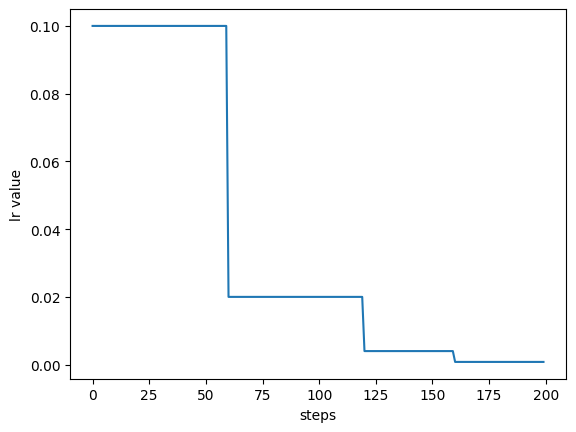

In [ ]:
plt.plot(lr_arr)  
plt.xlabel('steps')
plt.ylabel('lr value')
plt.show()

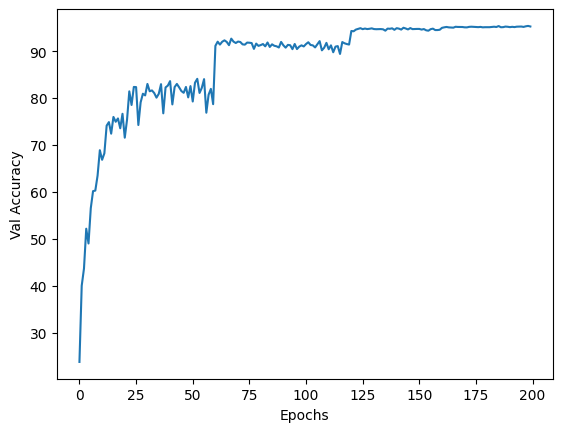

In [ ]:
plt.plot(val_acc)  
plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')
plt.show()

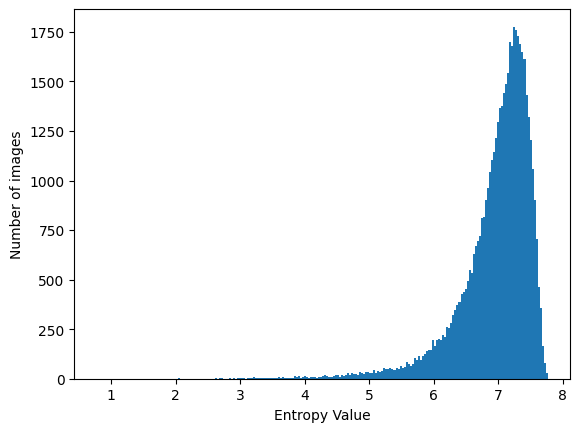

In [ ]:
# Draw entropy histogram
import math
n = len(entropy_values)
range_val = max(entropy_values) - min(entropy_values)
root = int(math.sqrt(n));
intervals_Width = range_val/root
bins = [(min(entropy_values) + (x * intervals_Width)) for x in np.arange (0, root, 1)]
plt.hist(entropy_values, bins=bins)
plt.xlabel('Entropy Value')
plt.ylabel('Number of images')
plt.show()

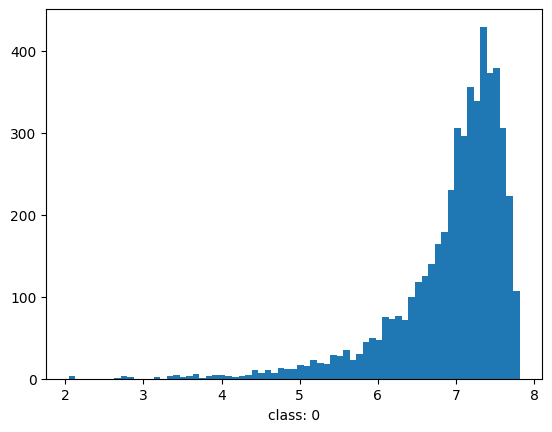

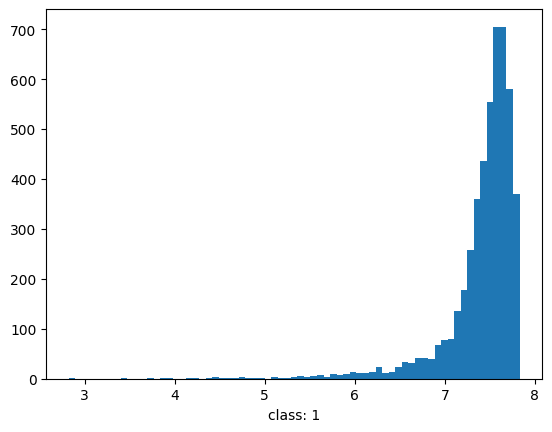

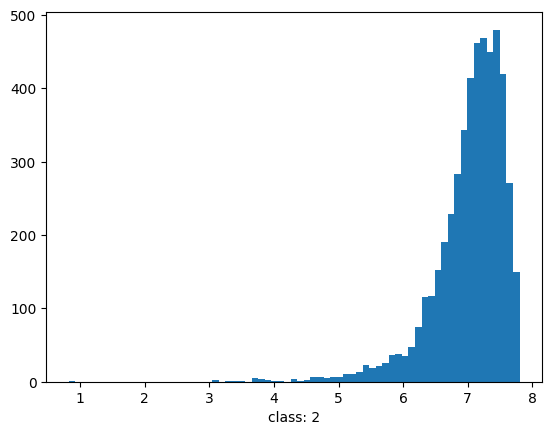

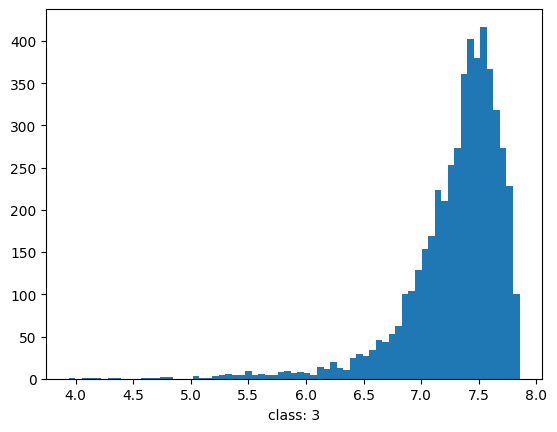

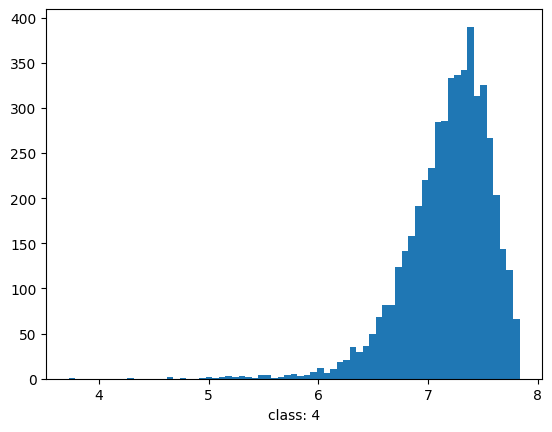

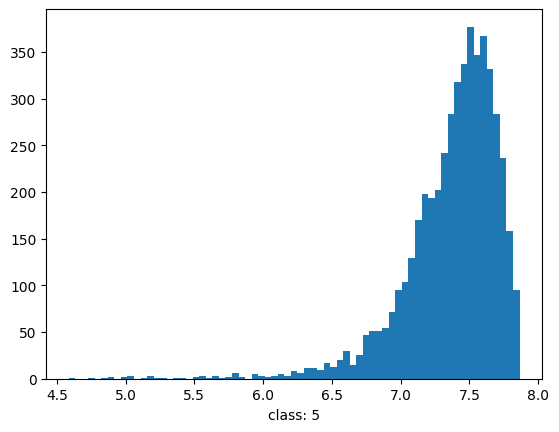

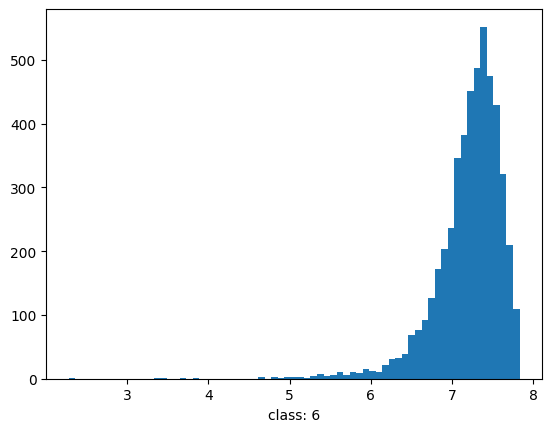

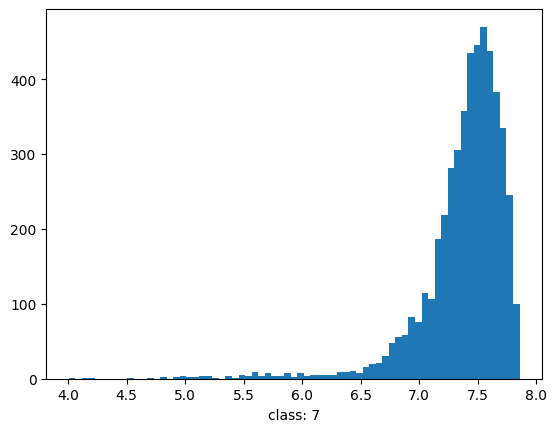

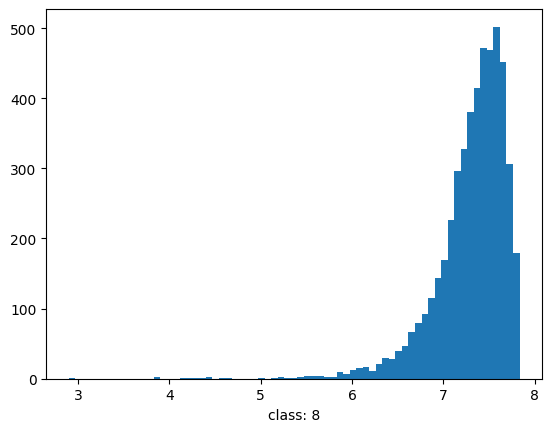

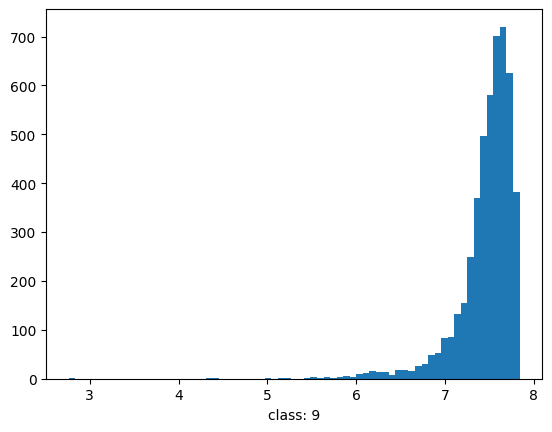

In [ ]:
# Draw entropy histograms per class
def get_entropies_by_class(dataset, class_num):
  entropies = []
  for item in dataset :
     if item[1] == class_num:
        entropy = calculate_entropy(item[0])
        entropies.append(entropy)
  return entropies
 
import math
for index in range(10):
  entropy_values = get_entropies_by_class(trainset, index)
 
  n = len(entropy_values)
  range_val = max(entropy_values) - min(entropy_values)
  root = int(math.sqrt(n));
  intervals_Width = range_val/root
  bins = [(min(entropy_values) + (x * intervals_Width)) for x in np.arange (0, root, 1)]
  plt.hist(entropy_values, bins=bins)
  plt.xlabel('class: ' + str(index))
  plt.show()